In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd


def load_object(path: str):
    try:
        image = Image.open(path)
        image = image.convert('L')
        image.resize((28, 28))
        return np.array(image).reshape(-1)
    except Exception as e:
        print(f"load_object exception: {e}")
        return None


def display_object(path: str):
    print(path)
    plt.imshow(Image.fromarray(load_object(path)).convert('RGB'))


def display_first_objects(path: str):
    for dirname in os.listdir(path):
        dirpath = os.path.join(path, dirname)
        if not os.path.isdir(dirpath):
            continue

        for filename in os.listdir(dirpath):
            filepath = os.path.join(dirpath, filename)
            display_object(filepath)
            break

        plt.axis("off")
        plt.show()

In [ ]:
display_first_objects('data/letters_small')

In [4]:
TARGET_LABELS = ['target']
FEATURE_LABELS = ['path']
PIXEL_FEATURE_LABELS = []


def load_data(path: str):
    rows = []
    for dirname in os.listdir(path):
        dirpath = os.path.join(path, dirname)
        if not os.path.isdir(dirpath):
            continue

        objects = (
            {'target': dirname, 'data': load_object(os.path.join(dirpath, file)), 'path': os.path.join(dirpath, file)}
            for file in os.listdir(dirpath)
            if os.path.isfile(os.path.join(dirpath, file)) and os.path.getsize(os.path.join(dirpath, file)) > 0
        )
        rows.extend(objects)

    frame = pd.DataFrame(rows).dropna()
    flattened_data = np.stack(frame['data'].values)
    global PIXEL_FEATURE_LABELS
    PIXEL_FEATURE_LABELS = [f'data_pixel_{i}' for i in range(flattened_data.shape[1])]
    flattened_df = pd.DataFrame(flattened_data, columns=PIXEL_FEATURE_LABELS)
    result = pd.concat([frame[TARGET_LABELS + FEATURE_LABELS], flattened_df], axis=1)
    return result.dropna()

In [5]:
# Task 2
df = load_data("data/letters_small")

In [6]:
from sklearn.model_selection import train_test_split


def split_data(data, train_size=0.6, val_size=0.2, test_size=0.2):
    assert train_size + val_size + test_size == 1, "The sum of train_size, val_size, and test_size must be 1"

    X_tv, X_test, y_tv, y_test = train_test_split(data[FEATURE_LABELS + PIXEL_FEATURE_LABELS], data[TARGET_LABELS], test_size=test_size, random_state=42)

    val_size_relative = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=val_size_relative, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
# Task 4. Drop duplicates
df.drop_duplicates(subset=PIXEL_FEATURE_LABELS)

,target,path,data_pixel_0,data_pixel_1,data_pixel_2,data_pixel_3,data_pixel_4,data_pixel_5,data_pixel_6,data_pixel_7,...,data_pixel_774,data_pixel_775,data_pixel_776,data_pixel_777,data_pixel_778,data_pixel_779,data_pixel_780,data_pixel_781,data_pixel_782,data_pixel_783
0,I,data/letters_small/I/Qml0d2lzZS50dGY=.png,152,172,216,240,251,255,255,255,...,255,255,255,255,255,252,243,221,179,160
1,I,data/letters_small/I/RW5nbGFuZCBCb2xkSXRhbGljL...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,I,data/letters_small/I/R3JlZWsgSXRhbGljLnR0Zg==.png,0,0,0,0,0,0,1,1,...,62,0,2,0,0,0,0,0,0,0
3,I,data/letters_small/I/Rmx5d2hlZWxTcXVhcmUudHRm.png,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,I,data/letters_small/I/SGFuZGljYXAub3Rm.png,183,183,183,183,183,183,183,183,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18719,B,data/letters_small/B/QmFzZVR3ZWx2ZVNlcmlmU0NCL...,186,255,253,255,255,255,255,255,...,239,216,164,86,8,0,3,1,0,0
18720,B,data/letters_small/B/Q29tcGFjdGEucGZi.png,255,255,255,255,255,255,255,255,...,236,223,210,191,158,118,60,6,0,2
18721,B,data/letters_small/B/SVRDIEN1c2hpbmcgSGVhdnkuc...,255,255,255,255,255,255,255,255,...,198,168,127,63,15,0,0,3,1,0
18722,B,data/letters_small/B/QmVydGhhbUJvbGQudHRm.png,103,244,254,252,253,255,255,255,...,0,0,0,0,4,2,0,0,0,0


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression


set_sizes = np.linspace(0.05, 0.99, 10)
accuracies = []
for set_size in set_sizes:
    partial_frame, _ = train_test_split(df, test_size=set_size, random_state=42)

    # Task 3
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(partial_frame)

    ovo_clf = OneVsOneClassifier(
        LogisticRegression(random_state=42, max_iter=10_000, penalty='elasticnet', l1_ratio=0.9, solver='saga'),
        n_jobs=-1
    ).fit(X_train[PIXEL_FEATURE_LABELS], y_train.values.ravel())

    score = accuracy_score(y_test, ovo_clf.predict(X_test[PIXEL_FEATURE_LABELS]))
    accuracies.append(score)

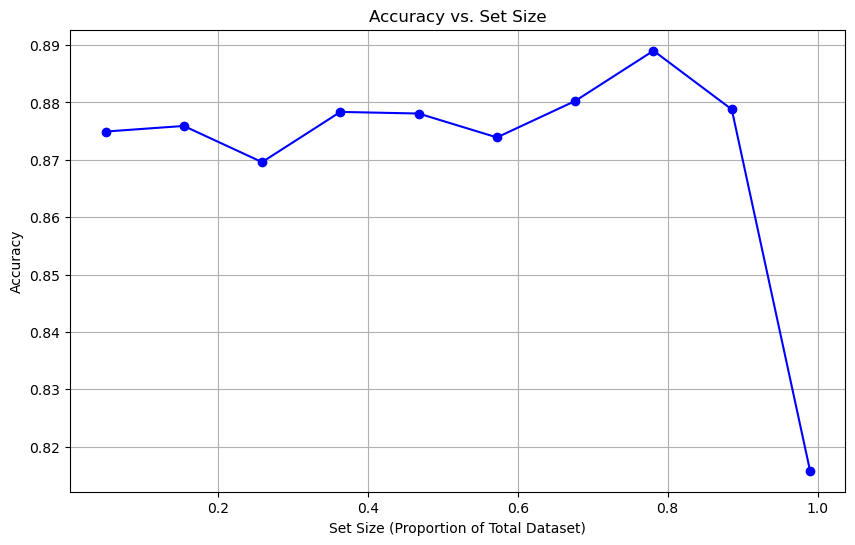

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(set_sizes, accuracies, marker='o', linestyle='-', color='b')

# Label the axes
plt.xlabel('Set Size (Proportion of Total Dataset)')
plt.ylabel('Accuracy')

# Add a title
plt.title('Accuracy vs. Set Size')

# Optionally, add grid lines for better readability
plt.grid(True)

# Display the plot
plt.show()

In [10]:
def predict_table(x_test):
    table = ovo_clf.predict(x_test[PIXEL_FEATURE_LABELS])
    table_df = pd.DataFrame(table, index=x_test.index, columns=['Predictions'])
    return pd.concat([x_test[FEATURE_LABELS], table_df, x_test[TARGET_LABELS]], axis=1)

def load_test_object(path: str, target: str):
    arr = load_object(path)
    print(f"Array size: {arr.shape}")
    return {'target': target, 'data': arr, 'path': path}


def df_from_rows(rows):
    frame = pd.DataFrame(rows).dropna()
    shapes = {arr.shape for arr in frame['data'].values}
    print(f"Shapes: {shapes}")
    flattened_data = np.stack(frame['data'].values)
    PIXEL_FEATURE_LABELS = [f'data_pixel_{i}' for i in range(flattened_data.shape[1])]
    flattened_df = pd.DataFrame(flattened_data, columns=PIXEL_FEATURE_LABELS)
    result = pd.concat([frame[TARGET_LABELS + FEATURE_LABELS], flattened_df], axis=1)
    return result.dropna()

paths = [
    {'path': 'data/test/a.png', 'target': 'a'},
    {'path': 'data/test/b.png', 'target': 'b'},
    {'path': 'data/test/c.png', 'target': 'c'},
    {'path': 'data/test/d.png', 'target': 'd'},
    {'path': 'data/test/f.png', 'target': 'f'},
    {'path': 'data/test/g.png', 'target': 'g'},
    {'path': 'data/test/h.png', 'target': 'h'},
    {'path': 'data/test/i.png', 'target': 'i'},
    {'path': 'data/test/j.png', 'target': 'j'},
]
rows = [load_test_object(obj['path'], obj['target']) for obj in paths]
test_frame = df_from_rows(rows)

predict_table(test_frame)

Array size: (784,)
Array size: (784,)
Array size: (784,)
Array size: (784,)
Array size: (784,)
Array size: (784,)
Array size: (784,)
Array size: (784,)
Array size: (784,)
Shapes: {(784,)}


,path,Predictions,target
0,data/test/a.png,A,a
1,data/test/b.png,B,b
2,data/test/c.png,C,c
3,data/test/d.png,C,d
4,data/test/f.png,I,f
5,data/test/g.png,C,g
6,data/test/h.png,H,h
7,data/test/i.png,I,i
8,data/test/j.png,I,j
